# 1. Importing packages

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/input'

# 2. Visualising data

In [ ]:
names = []
nums = []
data = {'Name of class':[],'Number of samples':[]}

for i in os.listdir(path+'/train'):
    nums.append(len(os.listdir(path+'/train/'+i)))
    names.append(i)

data['Name of class']+=names
data['Number of samples']+=nums

df = pd.DataFrame(data)
df

,Name of class,Number of samples
0,deer,600
1,cat,700
2,horse,600
3,dog,900


<Axes: xlabel='Name of class', ylabel='Number of samples'>

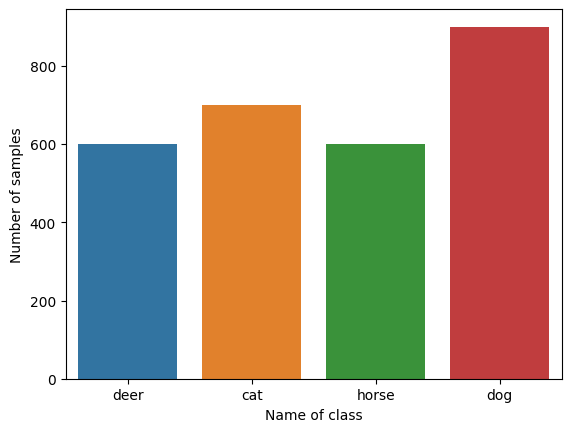

In [ ]:
sns.barplot(x=df['Name of class'],y=df['Number of samples'])

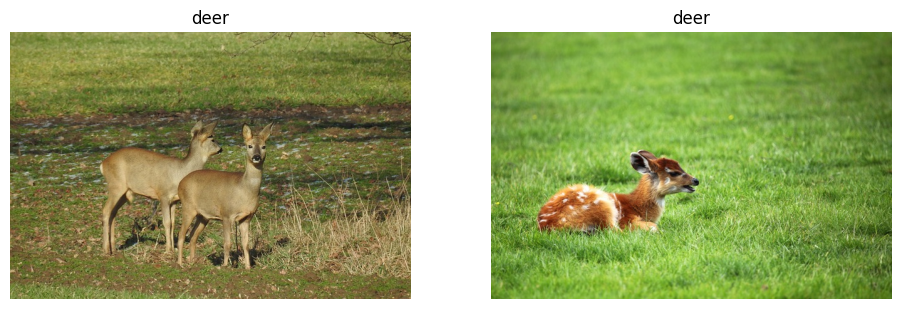

In [ ]:
classes = os.listdir(path+'/train')

plt.figure(figsize=(30 , 30))
for x in range(2):
    i = random.randint(0,3)                    # getting the class
    images = os.listdir(path+'/train'+'/'+classes[0])
    j = random.randint(0,5)                  # getting the image
    image = cv2.imread(path+'/train'+'/'+classes[0]+'/'+images[j])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(5, 5, x + 1)
    plt.imshow(image)
    plt.title(classes[0])
    plt.axis("off")

plt.show()

# 3. Preparing the data

In [ ]:
import splitfolders  # or import split_folders

# Split dengan ratio.
# Untuk hanya membagi menjadi set pelatihan dan validasi, setel tuple menjadi `ratio`, i.e, `(.7, .3)`.
splitfolders.ratio(path, output='split/spilt73', seed=1337, ratio=(.7, .3), group_prefix=None)

Copying files: 0 files [00:00, ? files/s]


In [ ]:
train_dir = '/content/drive/MyDrive/split/spilt73/train'
validation_dir = '/content/drive/MyDrive/split/spilt73/val'

In [ ]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255 , rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [ ]:
train_ds = image_datagen.flow_from_directory(
        train_dir,
        target_size=(224 , 224),
        batch_size=32)

val_ds = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224 , 224),
        batch_size=32 )

Found 1959 images belonging to 4 classes.
Found 841 images belonging to 4 classes.


# 4. Building the model

In [ ]:
# # i'll be using inception_v3 for this model , along with 2 extra dense layers and the output layer

mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224 , 224, 3),
                                           include_top=False,
                                           weights='imagenet')

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
from tensorflow.keras.applications import ResNet50
resNet50 = ResNet50(
    input_shape=(224 , 224, 3),
    include_top=False,
    weights='imagenet')

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
model = tf.keras.models.Sequential([
    mobilenet,
    # resNet50,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                        

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

# 5. Training and evaluating

In [ ]:
history = model.fit(
    train_ds, 
    validation_data = val_ds, 
    epochs = 20, 
    callbacks=[reduce_lr]
  )

Epoch 1/20
62/62 [==============================] - 1087s 17s/step - loss: 0.6989 - accuracy: 0.7182 - val_loss: 0.3163 - val_accuracy: 0.9239 - lr: 0.0100
Epoch 2/20
62/62 [==============================] - 47s 757ms/step - loss: 0.2974 - accuracy: 0.8964 - val_loss: 0.1825 - val_accuracy: 0.9441 - lr: 0.0100
Epoch 3/20
62/62 [==============================] - 46s 744ms/step - loss: 0.2047 - accuracy: 0.9285 - val_loss: 0.1376 - val_accuracy: 0.9584 - lr: 0.0100
Epoch 4/20
62/62 [==============================] - 44s 706ms/step - loss: 0.1642 - accuracy: 0.9474 - val_loss: 0.1298 - val_accuracy: 0.9631 - lr: 0.0100
Epoch 5/20
62/62 [==============================] - 44s 708ms/step - loss: 0.1230 - accuracy: 0.9581 - val_loss: 0.1350 - val_accuracy: 0.9631 - lr: 0.0100
Epoch 6/20
62/62 [==============================] - 48s 784ms/step - loss: 0.1359 - accuracy: 0.9535 - val_loss: 0.1236 - val_accuracy: 0.9655 - lr: 0.0100
Epoch 7/20
62/62 [==============================] - 44s 708ms/st

27/27 [==============================] - 7s 247ms/step - loss: 0.1171 - accuracy: 0.9667


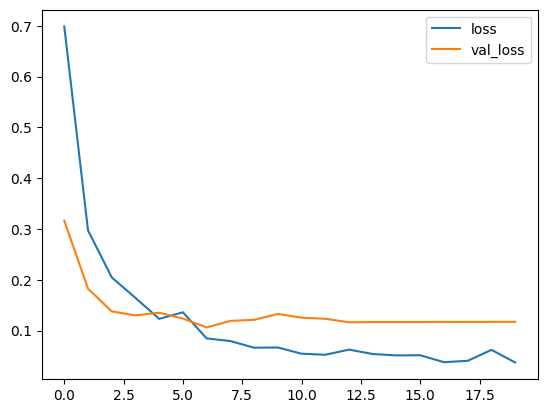

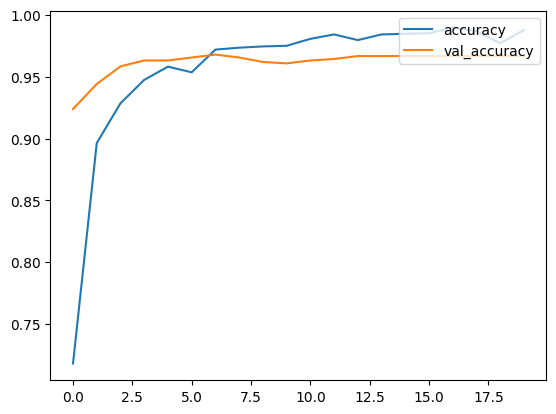

In [ ]:
model.evaluate(val_ds)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

In [ ]:
model.save_weights("model.h5")